In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


In [2]:
def generate_moons(n_samples=1000):
    X, _ = make_moons(n_samples=n_samples, noise=0.1)
    X = X.astype(np.float32)
    return torch.tensor(X)


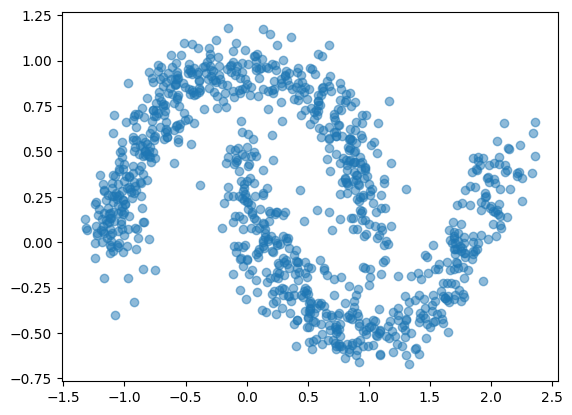

In [65]:
data_samples = generate_moons(n_samples=1000)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)

In [40]:
def simple_mlp(in_dim, hidden_dim, out_dim):
    return nn.Sequential(
        nn.Linear(in_dim+1, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
    )
    

In [69]:
print(T)

100


In [125]:

class DDPM:
    def __init__(self, in_dim=2, hidden_dim=128, out_dim=2, T=100, mlp_model=None):
        self.T = T
        self.betas = torch.linspace(0.0001, 0.02, T).numpy()
        self.alphas = 1 - self.betas
        self.alphas_cumprod = np.cumprod(self.alphas)
        self.model =mlp_model if mlp_model else simple_mlp(in_dim, hidden_dim, out_dim).to(torch.device("cpu"))
       
    def forward_diffusion(self, x0, t):
        noise = torch.randn_like(x0)
        # print(f"{self.alphas_cumprod[t]=}")
        mean = torch.sqrt(torch.tensor(self.alphas_cumprod[t]))[:, None] * x0
        std = torch.sqrt(1 - torch.tensor(self.alphas_cumprod[t]))[:, None]
        # print(f"{mean.shape=}")
        return mean + std * noise, noise
    
    def get_eps_from_model(self, x, t):
        with torch.no_grad():
            return self.model(torch.cat((x, torch.full((x.shape[0], 1), t / self.T)), dim=1))

    def get_eps_from_model_batch(self, x, t):
        with torch.no_grad():
            t = t / self.T
            t = t.float().view(-1, 1)  # Reshape t to be a column vector
            # Concatenate x and t along the feature dimension
            return self.model(torch.cat((x, t), dim=1))

    def compute_mu(self, x, eps, t):
        return (x - self.betas[t] / np.sqrt(1 - self.alphas_cumprod[t]) * eps) / np.sqrt(self.alphas[t])

    def compute_mu_batch(self, x, eps, t):
        # Ensure t is a tensor of integers
        t = t.long()

        # Index into betas, alphas_cumprod, and alphas using the batch of timesteps t
        betas_t = torch.tensor(self.betas[t])  # Shape: (batch_size,)
        alphas_cumprod_t = torch.tensor(self.alphas_cumprod[t])  # Shape: (batch_size,)
        alphas_t = torch.tensor(self.alphas[t])  # Shape: (batch_size,)

        # Compute the reverse process mean (mu)
        mu = (x - betas_t / torch.sqrt(1 - alphas_cumprod_t) * eps) / torch.sqrt(alphas_t)
        
        return mu

    def sample(self, n_samples=1000):
        x = torch.randn(n_samples, 2)
        for t in reversed(range(self.T)):
            z = torch.randn_like(x) if t > 0 else 0
            eps = self.get_eps_from_model(x, t)
            mu = self.compute_mu(x, eps, t)
            x = mu + np.sqrt(self.betas[t]) * z
        return x.detach().numpy()



def train_ddpm(ddpm_model, epochs=5000, batch_size=128, lr=3e-2, n_samples=5000):

    optimizer = optim.Adam(ddpm_model.model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    dataset = generate_moons(n_samples)
    for epoch in range(epochs):
        idx = torch.randint(0, dataset.shape[0], (batch_size,))
        x0 = dataset[idx]
        t = np.random.randint(0, ddpm_model.T, (batch_size,))
        xt, noise = ddpm_model.forward_diffusion(x0, t)
        noise_pred = ddpm_model.model(torch.cat((xt, torch.tensor(t[:, None]) / ddpm_model.T), dim=1))
        loss = criterion(noise_pred, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0332
Epoch 500, Loss: 0.5948
Epoch 1000, Loss: 0.4923
Epoch 1500, Loss: 0.4758
Epoch 2000, Loss: 0.5675
Epoch 2500, Loss: 0.4395
Epoch 3000, Loss: 0.5078
Epoch 3500, Loss: 0.3989
Epoch 4000, Loss: 0.5247
Epoch 4500, Loss: 0.4850
Epoch 5000, Loss: 0.5421
Epoch 5500, Loss: 0.5238
Epoch 6000, Loss: 0.5138
Epoch 6500, Loss: 0.6442
Epoch 7000, Loss: 0.5692
Epoch 7500, Loss: 0.6715
Epoch 8000, Loss: 0.6083
Epoch 8500, Loss: 0.4967
Epoch 9000, Loss: 0.3987
Epoch 9500, Loss: 0.4319
Epoch 10000, Loss: 0.5762
Epoch 10500, Loss: 0.5044
Epoch 11000, Loss: 0.4904
Epoch 11500, Loss: 0.5437
Epoch 12000, Loss: 0.5279
Epoch 12500, Loss: 0.5567
Epoch 13000, Loss: 0.4930
Epoch 13500, Loss: 0.4991
Epoch 14000, Loss: 0.4960
Epoch 14500, Loss: 0.5015
Epoch 15000, Loss: 0.5028
Epoch 15500, Loss: 0.5221
Epoch 16000, Loss: 0.4181
Epoch 16500, Loss: 0.5679
Epoch 17000, Loss: 0.4606
Epoch 17500, Loss: 0.4855
Epoch 18000, Loss: 0.4326
Epoch 18500, Loss: 0.4306
Epoch 19000, Loss: 0.5095
Epoch 1950

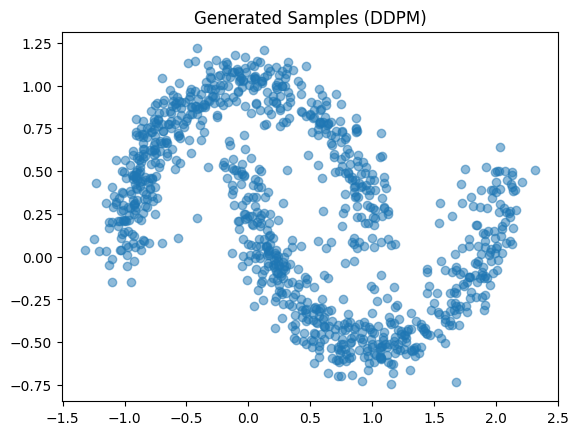

In [75]:
ddpm = DDPM()
train_ddpm(ddpm, epochs=20000, batch_size=128, lr=1e-3, n_samples=5000)
samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

In [34]:
print(sum(p.numel() for p in ddpm.model.parameters()))

17282


In [47]:
# trying with a bigger MLP

def mlp(in_dim, hidden_dim, out_dim):

    return nn.Sequential(
        nn.Linear(in_dim+1, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, 2*  hidden_dim),
        nn.ReLU(),
        nn.Linear(2*hidden_dim, 2*  hidden_dim),
        nn.ReLU(),
        nn.Linear(2*hidden_dim, out_dim)
    )
    


Epoch 0, Loss: 0.9097
Epoch 500, Loss: 0.5676
Epoch 1000, Loss: 0.4470
Epoch 1500, Loss: 0.5213
Epoch 2000, Loss: 0.4324
Epoch 2500, Loss: 0.3887
Epoch 3000, Loss: 0.5639
Epoch 3500, Loss: 0.6045
Epoch 4000, Loss: 0.5717
Epoch 4500, Loss: 0.5141
Epoch 5000, Loss: 0.5490
Epoch 5500, Loss: 0.5010
Epoch 6000, Loss: 0.4892
Epoch 6500, Loss: 0.5942
Epoch 7000, Loss: 0.4546
Epoch 7500, Loss: 0.4534
Epoch 8000, Loss: 0.4429
Epoch 8500, Loss: 0.4696
Epoch 9000, Loss: 0.5413
Epoch 9500, Loss: 0.5371


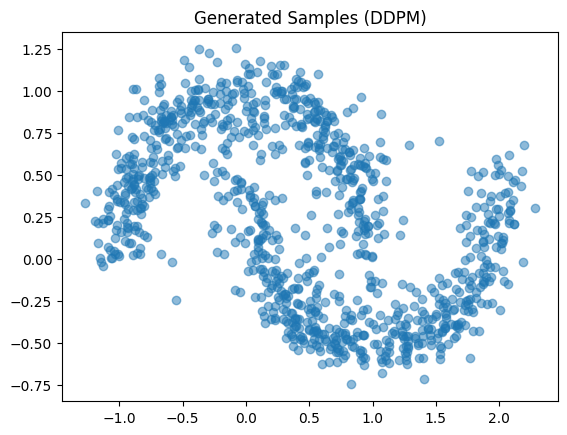

In [126]:
mlp_model = mlp(2,128, 2)
ddpm = DDPM()
train_ddpm(ddpm, epochs=10000, batch_size=128, lr=1e-2, n_samples=5000)
samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

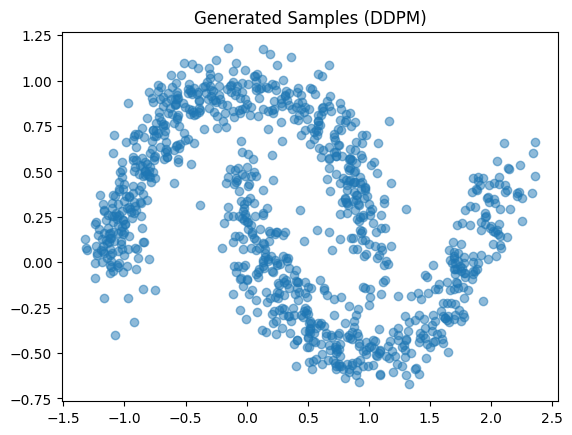

In [62]:

samples = ddpm.sample()
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (DDPM)")
plt.show()

## Consistency model training with distillation diffusion

In [115]:
class ConsistencyModel(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=128, out_dim=2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim)
        )
    
    def forward(self, x):
        return self.model(x)


def cm_sample(cm, n_samples=1000):
    x = torch.randn(n_samples, 2)
    with torch.no_grad():
        x = cm(x)
    return x.detach().numpy()

In [161]:
def one_step_euler_ode_solver(ddpm_model, x, t):
    # 1. Get the predicted noise (eps) from the model at the current timestep t
    # print(f"{t.shape=}")
    # print(f"{x.shape=}")
    eps = ddpm_model.get_eps_from_model_batch(x, t)
    
    # 2. Compute the reverse process mean (mu) at timestep t
    mu = compute_mu_batch(ddpm_model, x, eps, t)
    # print(f"{mu.shape=}")
    # 3. Sample random noise for the reverse diffusion step (except at t=0)
    # print(f"{t.shape=}")
    batch_size, out_dim = x.shape
    z = torch.cat([torch.randn((out_dim,) ).unsqueeze(0) if t[i] > 0 else torch.zeros_like((out_dim,)).unsqueeze(0) for i in range(batch_size)], dim=0)
    # print(f"{z.shape=}")
    # 4. Perform the Euler update: x_t = mu_t + sqrt(beta(t)) * z
    t = t.long()
    betas_t = torch.tensor(ddpm_model.betas[t]).view(-1,1)
    x_t_minus_1 = mu + torch.sqrt(betas_t) * z
    
    return x_t_minus_1


def compute_mu_batch(ddpm_model, x, eps, t):
    t = t.long()
    self = ddpm_model
    # Index into betas, alphas_cumprod, and alphas using the batch of timesteps t
    betas_t = torch.tensor(self.betas[t])  # Shape: (batch_size,)
    alphas_cumprod_t = torch.tensor(self.alphas_cumprod[t])  # Shape: (batch_size,)
    alphas_t = torch.tensor(self.alphas[t])  # Shape: (batch_size,)
    betas_t = betas_t.view(-1,1)
    alphas_t = alphas_t.view(-1,1)
    alphas_cumprod_t = alphas_cumprod_t.view(-1,1)
    # Compute the reverse process mean (mu)
    mu = (x - betas_t / torch.sqrt(1 - alphas_cumprod_t) * eps) / torch.sqrt(alphas_t)
    # print(f"{ betas_t.shape=}")
    return mu


In [163]:
def train_consistency_model(ddpm, cm, epochs=5000, batch_size=128, mu=0.90):
    dataset = generate_moons(1000)
    optimizer = optim.Adam(cm.parameters(), lr=1e-5)
    criterion = nn.MSELoss()
    cm_shadow = ConsistencyModel()
    cm_shadow.load_state_dict(cm.state_dict())
    
    for epoch in range(epochs):
        idx = torch.randint(0, dataset.shape[0], (batch_size,))
        x0 = dataset[idx]
        n = torch.randint(1, ddpm.T - 1, (batch_size,))
        xt, _ = ddpm.forward_diffusion(x0, n)
        
        with torch.no_grad():
            x_tn = xt + (1.0 / ddpm.T) * one_step_euler_ode_solver(ddpm, xt, n)
        
        cm_pred = cm(xt)
        loss = criterion(cm_pred, x_tn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Exponential moving average 
        for param, shadow_param in zip(cm.parameters(), cm_shadow.parameters()):
            # param.data for stopgrad
            shadow_param.data = mu * shadow_param.data + (1 - mu) * param.data
        
        if epoch % 500 == 0:
            print(f"CM Epoch {epoch}, Loss: {loss.item():.6f}")

In [159]:
t = torch.randn((128))
print(t.shape)
t = t.float().view(-1, 1)  # Reshape t to be a column vector
print(t.shape)
x =torch.randn((128,2))
res = torch.cat((x, t), dim=1)
print(res.shape)

torch.Size([128])
torch.Size([128, 1])
torch.Size([128, 3])


CM Epoch 0, Loss: 0.828283
CM Epoch 500, Loss: 0.412368
CM Epoch 1000, Loss: 0.171163
CM Epoch 1500, Loss: 0.056389
CM Epoch 2000, Loss: 0.015003
CM Epoch 2500, Loss: 0.005672
CM Epoch 3000, Loss: 0.001951
CM Epoch 3500, Loss: 0.000831
CM Epoch 4000, Loss: 0.000341
CM Epoch 4500, Loss: 0.000323
CM Epoch 5000, Loss: 0.000284
CM Epoch 5500, Loss: 0.000145
CM Epoch 6000, Loss: 0.000087
CM Epoch 6500, Loss: 0.000069
CM Epoch 7000, Loss: 0.000107
CM Epoch 7500, Loss: 0.000065
CM Epoch 8000, Loss: 0.000040
CM Epoch 8500, Loss: 0.000060
CM Epoch 9000, Loss: 0.000032
CM Epoch 9500, Loss: 0.000024
CM Epoch 10000, Loss: 0.000022
CM Epoch 10500, Loss: 0.000026
CM Epoch 11000, Loss: 0.000023
CM Epoch 11500, Loss: 0.000017
CM Epoch 12000, Loss: 0.000019
CM Epoch 12500, Loss: 0.000016
CM Epoch 13000, Loss: 0.000012
CM Epoch 13500, Loss: 0.000010
CM Epoch 14000, Loss: 0.000011
CM Epoch 14500, Loss: 0.000007
CM Epoch 15000, Loss: 0.000009
CM Epoch 15500, Loss: 0.000009
CM Epoch 16000, Loss: 0.000007
C

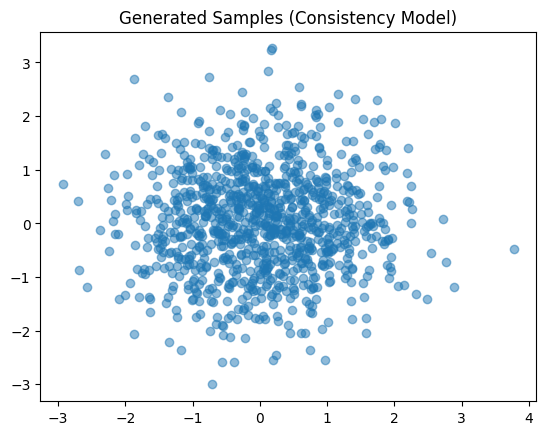

In [164]:
cm = ConsistencyModel()
train_consistency_model(ddpm, cm, epochs=20000)
samples = cm_sample(cm)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (Consistency Model)")
plt.show()


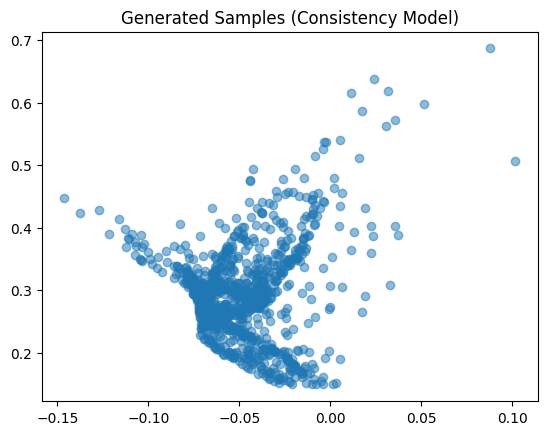

In [96]:
samples = cm_sample(cm)
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5)
plt.title("Generated Samples (Consistency Model)")
plt.show()